Purpose of this notebook:
1. Explore the data
2. Understand customer base
3. Explore factors that could affect the price column

#### Imports

In [1]:
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 
from sklearn.preprocessing import LabelEncoder
import pingouin as pg


#### Exploration

In [2]:
PATH = "./data/"

In [3]:
# reading files
customer_data = pd.read_csv(PATH + 'user_demographics_v1.csv', parse_dates=['reg_date'])
app_purchases = pd.read_csv(PATH + 'purchase_data_v1.csv',parse_dates=['date'])

In [4]:
# exploring the customer data
print(customer_data.head())
print(customer_data.columns)
print(customer_data.shape)
print("\n", customer_data.describe())

          uid                  reg_date device gender country  age
0  54030035.0 2017-06-29 00:00:00+00:00    and      M     USA   19
1  72574201.0 2018-03-05 00:00:00+00:00    iOS      F     TUR   22
2  64187558.0 2016-02-07 00:00:00+00:00    iOS      M     USA   16
3  92513925.0 2017-05-25 00:00:00+00:00    and      M     BRA   41
4  99231338.0 2017-03-26 00:00:00+00:00    iOS      M     FRA   59
Index(['uid', 'reg_date', 'device', 'gender', 'country', 'age'], dtype='object')
(10000, 6)

                 uid           age
count  1.000000e+04  10000.000000
mean   5.580304e+07     24.399200
std    2.562174e+07      9.772512
min    1.111609e+07     15.000000
25%    3.392627e+07     17.000000
50%    5.627628e+07     21.000000
75%    7.786440e+07     28.000000
max    9.999648e+07     84.000000


In [5]:
# exploring the app_purchases data
print(app_purchases.head())
print(app_purchases.columns)
print(app_purchases.shape)
print("\n", app_purchases.describe())

        date       uid            sku  price
0 2017-07-10  41195147  sku_three_499    499
1 2017-07-15  41195147  sku_three_499    499
2 2017-11-12  41195147   sku_four_599    599
3 2017-09-26  91591874    sku_two_299    299
4 2017-12-01  91591874   sku_four_599    599
Index(['date', 'uid', 'sku', 'price'], dtype='object')
(9006, 4)

                 uid        price
count  9.006000e+03  9006.000000
mean   5.719633e+07   406.772596
std    2.652288e+07   187.918230
min    1.115855e+07    99.000000
25%    3.421581e+07   299.000000
50%    5.790297e+07   299.000000
75%    8.172713e+07   499.000000
max    9.997504e+07   899.000000


In [6]:
# since both tables have a common key, 'uid', I'll merge on that column 
uid_combined_data = app_purchases.merge(customer_data, on='uid', how='inner')
uid_combined_data.head()

,date,uid,sku,price,reg_date,device,gender,country,age
0,2017-07-10,41195147,sku_three_499,499,2017-06-26 00:00:00+00:00,and,M,BRA,17
1,2017-07-15,41195147,sku_three_499,499,2017-06-26 00:00:00+00:00,and,M,BRA,17
2,2017-11-12,41195147,sku_four_599,599,2017-06-26 00:00:00+00:00,and,M,BRA,17
3,2017-09-26,91591874,sku_two_299,299,2017-01-05 00:00:00+00:00,and,M,TUR,17
4,2017-12-01,91591874,sku_four_599,599,2017-01-05 00:00:00+00:00,and,M,TUR,17


In [7]:
uid_combined_data.shape

(9006, 9)

In [8]:
print(uid_combined_data.isnull().sum())


date        0
uid         0
sku         0
price       0
reg_date    0
device      0
gender      0
country     0
age         0
dtype: int64


In [9]:
# count of customers in the dataset 
print("The number of customers in this dataset: ", uid_combined_data['uid'].nunique())


The number of customers in this dataset:  1322


#### Exploring different statistics 
<ol> <li>price is in cents</li></ol>

In [10]:
uid_combined_data.describe()

,uid,price,age
count,9.006000e+03,9006.000000,9006.000000
mean,5.719633e+07,406.772596,23.922274
std,2.652288e+07,187.918230,9.044646
min,1.115855e+07,99.000000,15.000000
25%,3.421581e+07,299.000000,17.000000
50%,5.790297e+07,299.000000,21.000000
75%,8.172713e+07,499.000000,28.000000
max,9.997504e+07,899.000000,75.000000


In [11]:
# checking for missing values 
uid_combined_data.isnull().sum()

date        0
uid         0
sku         0
price       0
reg_date    0
device      0
gender      0
country     0
age         0
dtype: int64

## Exploring price in relation to other variables

### Exploring Price


In [12]:
# exploring the price column , price is in cents 
purchase_price_summary = uid_combined_data.price.agg(['mean', 'median', 'std', 'min', 'max'])
purchase_price_summary

mean      406.772596
median    299.000000
std       187.918230
min        99.000000
max       899.000000
Name: price, dtype: float64

<AxesSubplot:>

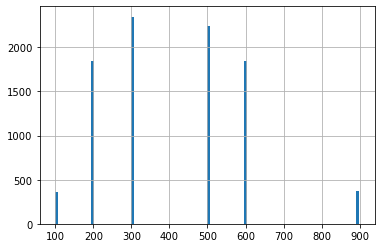

In [13]:
# now i'll look at the distribution of the price column
uid_combined_data.price.hist(bins=100)

<b> Observation </b>
<ul>
<li> The average price is $4 ($3.99) </li>
<li> The lowest price the subscription was going for is $1  and the highest is $9</li>

### Exploring Price & Age


In [14]:
# exploring the price & age columns
purchase_summary = uid_combined_data.agg({ 'age': ['mean', 'median', 'std', 'min', 'max']})
purchase_summary

,age
mean,23.922274
median,21.000000
std,9.044646
min,15.000000
max,75.000000


In [15]:
#  looking at each age group and its corresponding generated mean price
purchase_age = uid_combined_data.groupby('age').agg({'price': ['mean', 'median', 'std']})
purchase_age.head(10).sort_values(by=('price', 'mean'), ascending=False)

price                   
           mean median         std
age                               
15   415.405434  499.0  195.590605
17   414.138889  499.0  185.290007
21   409.062893  299.0  193.332659
16   406.593458  299.0  189.368426
23   406.455013  499.0  186.035556
18   405.049149  299.0  179.754898
19   404.821918  299.0  189.339402
20   404.613306  299.0  195.867962
24   399.923077  299.0  191.241260
22   398.025341  299.0  185.349715

<AxesSubplot:>

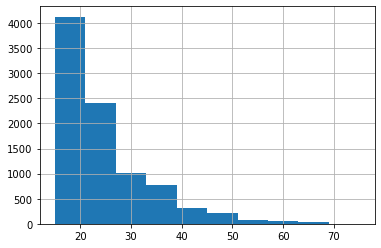

In [16]:
# age distribution
uid_combined_data.age.hist()

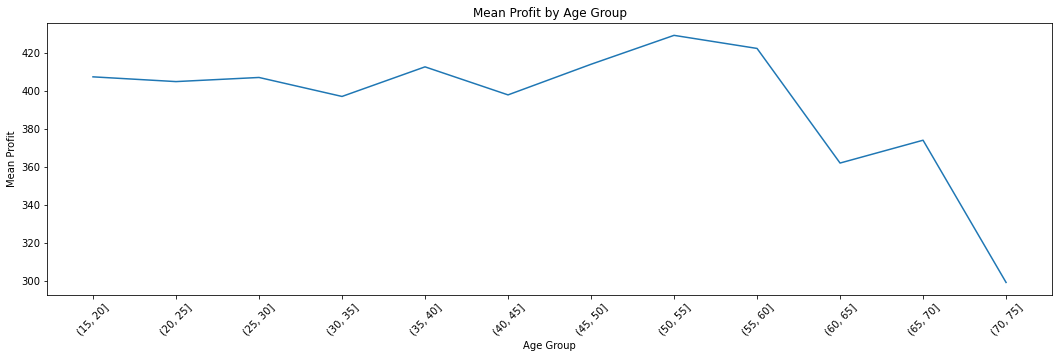

In [17]:
# Define custom age bins with a step size of 5
age_bins = np.arange(uid_combined_data.age.min(), uid_combined_data.age.max() + 5, 5)

uid_combined_data['age_group'] = pd.cut(uid_combined_data.age, bins=age_bins)

profit_by_age_group = uid_combined_data.groupby('age_group')['price'].mean()

fig = plt.figure(figsize=(18, 5))
plt.plot(profit_by_age_group.index.astype(str), profit_by_age_group.values)
plt.xlabel('Age Group')
plt.ylabel('Mean Profit')
plt.title('Mean Profit by Age Group')
plt.xticks(rotation=45)
plt.show()


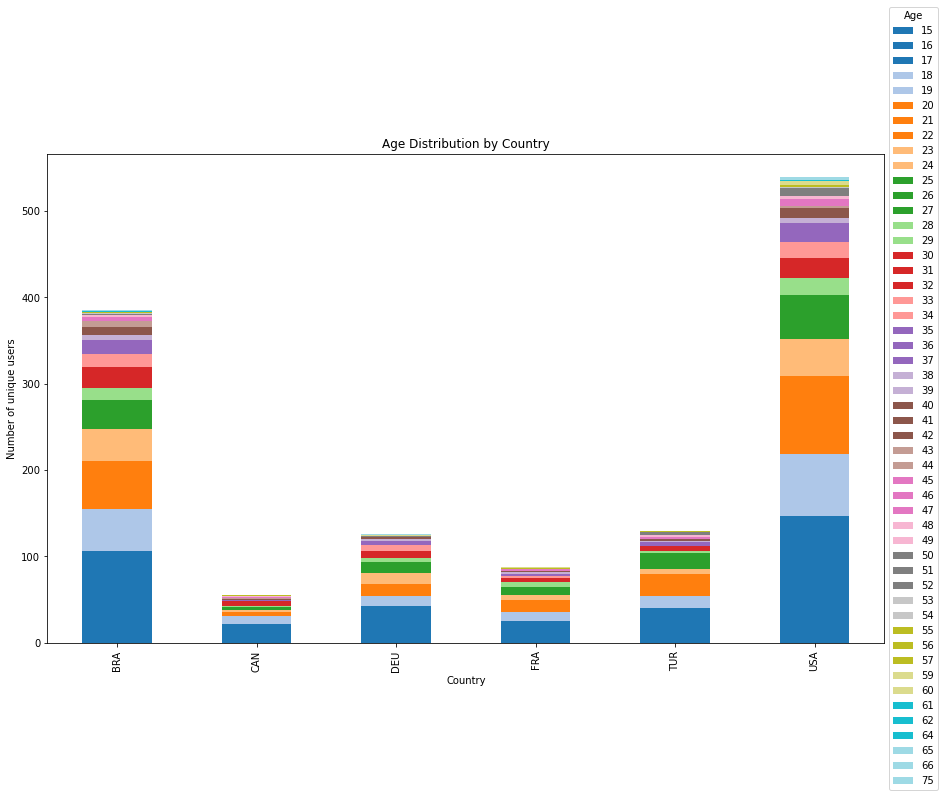

In [18]:
# looking at age distribution in each country

# unique users per country
age_counts_per_country = uid_combined_data.groupby(['country', 'age'])['uid'].nunique().reset_index(name='count')

# Pivot the data for visualization
age_distribution = age_counts_per_country.pivot(index='country', columns='age', values='count')

fig, ax = plt.subplots(figsize=(15, 9))
cmap = plt.get_cmap('tab20')
age_distribution.plot(kind='bar', ax=ax, cmap=cmap, stacked='percentage')

ax.set_xlabel('Country')
ax.set_ylabel('Number of unique users')
ax.set_title('Age Distribution by Country')
ax.legend(title='Age', loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

<b> Observation </b>
<ul>
<li> The average user's age is 24 years old, and as young as 15 years old  </li>
<li> Users aged 15 generate the highest income </li>
<li> Users between the ages of 15 and 24 generate the most amount of income compared to other ages, and account for the highest count of users </li>
<li> In all the countries the app operates in, the most amount of users are within the 15 - 24 year old range </li>

### Exploring Price & Gender

In [19]:
# how many females to males 
gender_ratio = uid_combined_data.groupby(['gender']).uid.nunique()
gender_ratio

gender
F    712
M    610
Name: uid, dtype: int64

In [20]:
# exploring price and gender 
purchase_gender = uid_combined_data.groupby('gender').agg({'price': ['mean', 'median', 'std', 'sum']})
purchase_gender


price                            
              mean median         std      sum
gender                                        
F       402.276978  299.0  180.615135  1927309
M       411.882562  499.0  195.785251  1736085

In [21]:
# because the mean doesn't align with the sum, i'll check for a significant difference between the mean price generated by males and females, 
male_data = uid_combined_data[uid_combined_data['gender']=='M']['price']
female_data = uid_combined_data[uid_combined_data['gender']=='F']['price']

# Perform a two-sample t-test
t_statistic, p_value = stats.ttest_ind(male_data, female_data)

# Check if the p-value is significant (e.g. less than 0.05)
if p_value < 0.05:
    print('There is a significant difference between the mean price generated by males and females.')
else:
    print('There is not a significant difference between the mean price generated by males and females.')



There is a significant difference between the mean price generated by males and females.


In [22]:
# since there is a significance between the mean price generated both genders, i'll explore whether there is a relationship between gender and price

# Create dummy variables for gender
uid_combined_data["is_female"] = pd.get_dummies(uid_combined_data["gender"])["F"]

# Fit a linear regression model
X = sm.add_constant(uid_combined_data[["is_female"]])
y = uid_combined_data["price"]
model = sm.OLS(y, X).fit()

# Print the summary statistics
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     5.862
Date:                Fri, 14 Jul 2023   Prob (F-statistic):             0.0155
Time:                        16:27:10   Log-Likelihood:                -59931.
No. Observations:                9006   AIC:                         1.199e+05
Df Residuals:                    9004   BIC:                         1.199e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        411.8826      2.894    142.338      0.0

It seems that gender does play a part in how much revenue is generated. Males are more likely to pay, an average of 9.6056 more than females. 

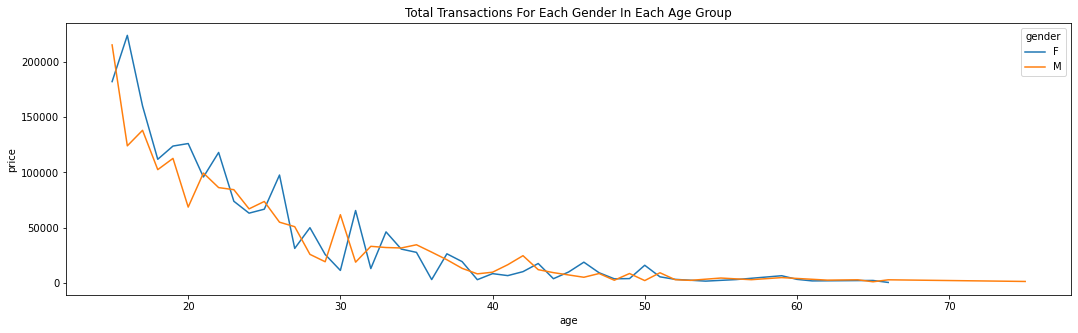

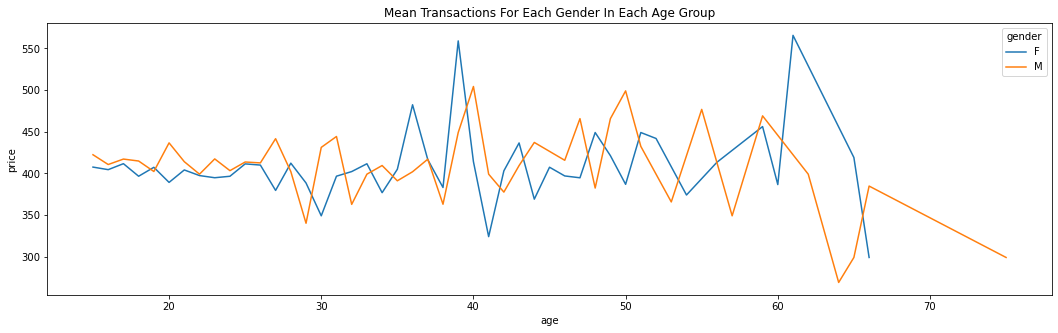

In [23]:
# is it a specific gender within the different age groups that is more likely to pay more for the subscription?
purchase_age_group_sum = uid_combined_data.groupby(['age', 'gender']).agg({'price': 'sum'})
purchase_age_group_mean = uid_combined_data.groupby(['age', 'gender']).agg({'price': 'mean'})

purchase_age_group_sum = purchase_age_group_sum.reset_index()
purchase_age_group_mean = purchase_age_group_mean.reset_index()

# plot 
plt.figure(figsize=(18, 5))
p = sns.lineplot(x='age', y='price', hue='gender', data=purchase_age_group_sum)
plt.title("Total Transactions For Each Gender In Each Age Group")
plt.show()

plt.figure(figsize=(18, 5))
p = sns.lineplot(x='age', y='price', hue='gender', data=purchase_age_group_mean)
plt.title("Mean Transactions For Each Gender In Each Age Group")
plt.show()

In [24]:
# Calculate the total purchase amount for males and females within the typical user age range
male_age_filtered_total_purchase = purchase_age_group_sum[purchase_age_group_sum['gender']=='M'].price.sum()
female_age_filtered_total_purchase = purchase_age_group_sum[purchase_age_group_sum['gender']=='F'].price.sum()

# Calculate the mean purchase amount for males and females within the typical user age range
male_age_filtered_mean_purchase = purchase_age_group_mean[purchase_age_group_mean['gender']=='M'].price.sum()
female_age_filtered_mean_purchase = purchase_age_group_mean[purchase_age_group_mean['gender']=='F'].price.sum()

# Compare the total purchase amount for males and females within the typical user age range
# and print the result
if male_age_filtered_total_purchase > female_age_filtered_total_purchase:
    print("Males Generated more revenue in total  = {}".format(male_age_filtered_total_purchase))
else:
    print("Females generated more revenue in total =  {}".format(female_age_filtered_total_purchase))

# Compare the mean purchase amount for males and females within the typical user age range
# and print the result
if male_age_filtered_mean_purchase > female_age_filtered_mean_purchase:
    print("Males generated more revenue on average = ${}".format(male_age_filtered_mean_purchase))
else:
    print("Females generated more revenue on average  = ${}".format(female_age_filtered_mean_purchase))


Females generated more revenue in total =  1927309
Males generated more revenue on average = $18713.467256847307


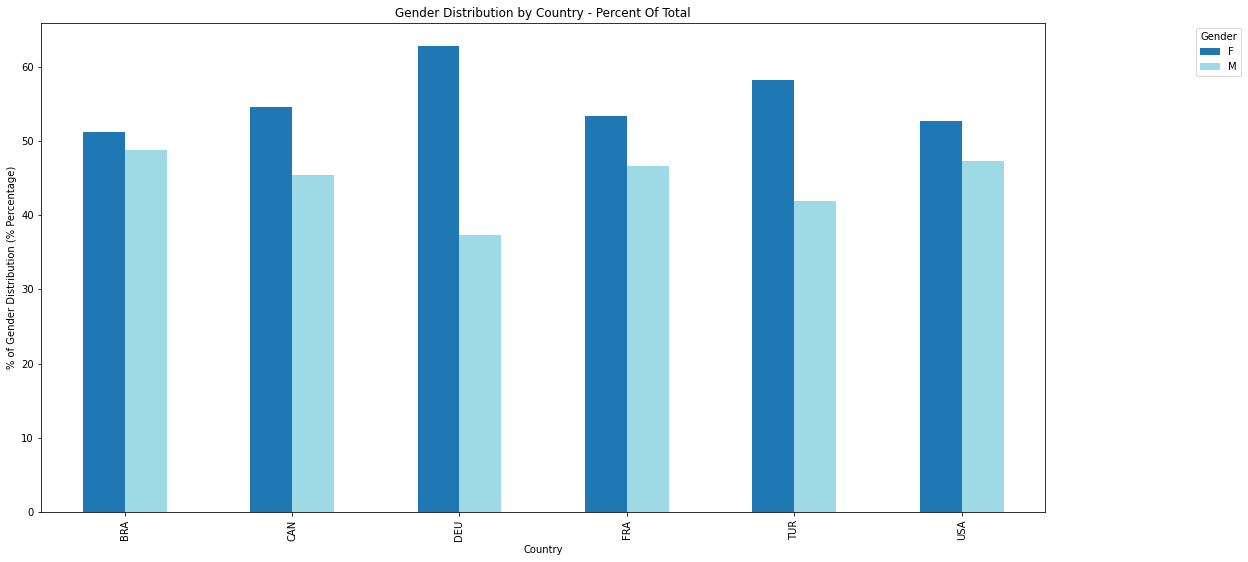

In [25]:
# Gender distribution by country

# Unique users per country
age_counts_per_country = uid_combined_data.groupby(['country', 'gender'])['uid'].nunique().reset_index(name='count')

# Calculate the total count per country
total_count_per_country = age_counts_per_country.groupby('country')['count'].sum().reset_index(name='total_count')

# Merge the total count per country with the age_counts_per_country DataFrame
age_counts_per_country = age_counts_per_country.merge(total_count_per_country, on='country')

# Calculate the percentage of each gender group in each country
age_counts_per_country['percentage'] = (age_counts_per_country['count'] / age_counts_per_country['total_count']) * 100

# Plot the gender distribution by country
fig, ax = plt.subplots(figsize=(18, 9))
cmap = plt.get_cmap('tab20')
age_counts_per_country.pivot(index='country', columns='gender', values='percentage').plot(kind='bar', ax=ax, cmap=cmap)

ax.set_xlabel('Country')
ax.set_ylabel('% of Gender Distribution (% Percentage)')
ax.set_title('Gender Distribution by Country - Percent Of Total')
ax.legend(title='Gender', loc='upper right', bbox_to_anchor=(1.2, 1))
plt.show()


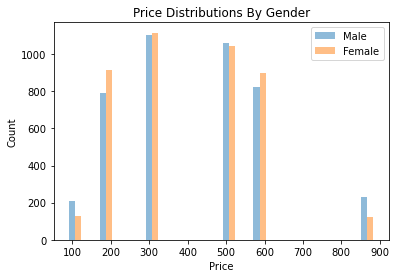

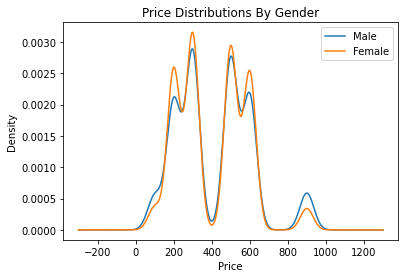

In [26]:
# plotting the perferred price point for each gender

# Resample the data to balance the sample size in each group
male_prices = uid_combined_data.loc[uid_combined_data['gender'] == 'M', 'price']
female_prices = uid_combined_data.loc[uid_combined_data['gender'] == 'F', 'price']

# random sample from each set
min_size = min(len(male_prices), len(female_prices))
male_prices = male_prices.sample(min_size, random_state=1)
female_prices = female_prices.sample(min_size, random_state=1)

##### price preferences for each gender ######
# Define the number of bins
num_bins = 20

# Calculate the histogram values and bins edges
male_hist_values, male_bins = np.histogram(male_prices, bins=num_bins)
female_hist_values, female_bins = np.histogram(female_prices, bins=num_bins)

# Define the bar width
width = 0.4 * (male_bins[1] - male_bins[0])

# Plot the histograms next to each other
plt.bar(male_bins[:-1], male_hist_values, width=width, alpha=0.5, label="Male")
plt.bar(female_bins[:-1] + width, female_hist_values, width=width, alpha=0.5, label="Female")

plt.xlabel("Price")
plt.ylabel("Count")
plt.title("Price Distributions By Gender")
plt.legend()
plt.show()


##### KDE plot #####
# plot kde
plt.figure()
male_prices.plot(kind='kde', label="Male")
female_prices.plot(kind='kde', label="Female")
plt.xlabel("Price")
plt.ylabel("Density")
plt.title("Price Distributions By Gender")
plt.legend()
plt.show()

<b> Observation </b>
<ul>
<li> There are more females then males </li>
<li> When looking at all the data males generate more on average , but females produce a higher total revenue</li>
<li> The gender does play into effect when it comes to revenue generation, it's statistically significant as seen from the t-test </li>
<li> Males are more likely to pay, an average of 9.6056 more than females </li>
<li> Both genders are likely to purchase subscriptions when the price is between $2 and $6, but the ideal price being closer to $3</li>
<li> Young adults account for the most amount of profit. </li>
<li> In all countries, there are more female users </li>
 



### Exploring Price & Country


In [27]:
# how many countries are there
uid_combined_data.country.nunique()

6

In [28]:
# how many unique users in each country 
unique_users_region = uid_combined_data.groupby('country').agg({'uid': 'nunique'}).sort_values(by='uid', ascending=False)
unique_users_region.reset_index()

,country,uid
0,USA,539
1,BRA,385
2,TUR,129
3,DEU,126
4,FRA,88
5,CAN,55


Text(0.5, 1.0, 'Unique Player Count by Country')

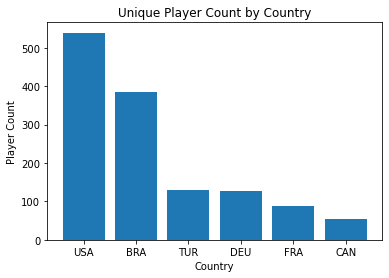

In [29]:
plt.bar(unique_users_region.index, unique_users_region.uid)
plt.xlabel('Country')
plt.ylabel('Player Count')
plt.title('Unique Player Count by Country')

In [30]:
purchase_region = uid_combined_data.groupby('country').agg({'price': ['mean', 'median', 'std', 'sum', 'count']})
purchase_region.sort_values(by = ('price', 'sum'), ascending=False).sort_values(by = ('price','mean'), ascending=False)

price                                  
               mean median         std      sum count
country                                              
TUR      415.417910  499.0  193.876633   333996   804
BRA      409.838901  499.0  191.504978  1104106  2694
DEU      409.054645  499.0  178.209847   374285   915
USA      403.712329  299.0  186.733872  1473550  3650
FRA      401.757353  299.0  186.396792   218556   544
CAN      398.248120  299.0  185.868695   158901   399

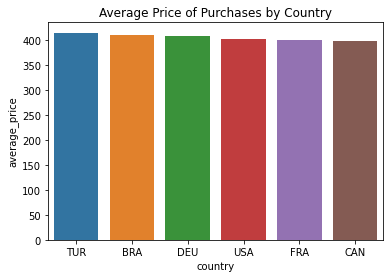

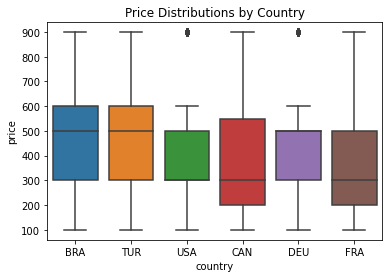

In [31]:
# calculating the average price of purchases per country 
average_prices = uid_combined_data.groupby('country')['price'].mean().reset_index(name='average_price').sort_values(by='average_price', ascending=False)

# plot the average prices 
sns.barplot(x='country', y='average_price', data=average_prices)
plt.title('Average Price of Purchases by Country')
plt.show()

# plot the distributions of prices
sns.boxplot(x='country', y='price', data=uid_combined_data)
plt.title('Price Distributions by Country')
plt.show()

In [32]:
# running an anova test to see if there is a significant difference between the average price of purchases in each country
# null hypothesis: there are no differences between the groups
anova_result = pg.anova(data=uid_combined_data, dv='price', between='country')
print(anova_result)

if anova_result['p-unc'][0] < 0.05:
    print("There is a significant difference between the average price of purchases in each country")
else:
    print("There is no significant difference between the average price of purchases in each country")

    Source  ddof1  ddof2         F     p-unc       np2
0  country      5   9000  0.946058  0.449733  0.000525
There is no significant difference between the average price of purchases in each country


<b> Observation </b>
<ul>
<li> USA has the highest number of unique users</li>
<li> USA has generated the most amount of revenue</li>
<li> Turkey & Brazil generated the highest average per user in revenue</li>
<li> The average subscription price is $4. </li>
<li> The countries with the most difference in purchase price are between Turkey and USA, and Brazil and Canada</li>
</ul>
 



### Exploring Price & Devices

In [33]:
# exploring unique users for each device
purchase_devices = uid_combined_data.groupby('device')['uid'].nunique().reset_index(name='count')
purchase_devices.head()

,device,count
0,and,790
1,iOS,532


In [34]:
# exploring devices and purchases
purchase_devices = uid_combined_data.groupby('device').agg({'price': ['mean', 'median', 'std', 'sum']})
purchase_devices.head().sort_values(by = ('price', 'mean'), ascending=False)

price                            
              mean median         std      sum
device                                        
and     408.111319  299.0  187.415789  2181355
iOS     404.818082  299.0  188.657954  1482039

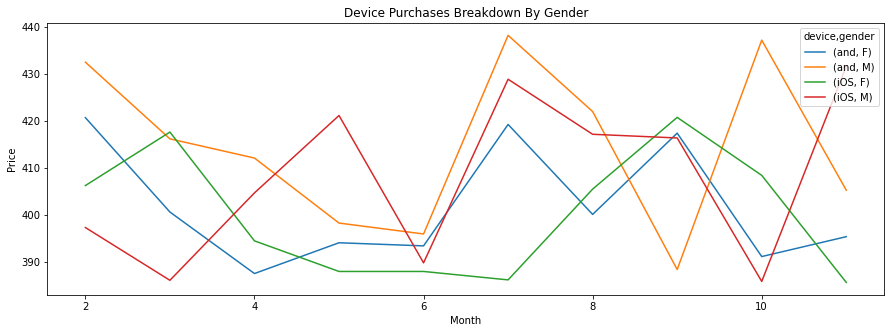

In [35]:
# Plotting gender and device again price
#   Pivot user_revenue
uid_combined_data['month'] = pd.to_datetime(uid_combined_data['date']).dt.month
pivoted_data = pd.pivot_table(uid_combined_data, values='price', columns=['device', 'gender'], index='month')
pivoted_data = pivoted_data[1:(len(pivoted_data) -1 )]

# Create and show the plot
pivoted_data.plot( figsize = (15, 5))
plt.xlabel('Month')
plt.ylabel('Price')
plt.title('Device Purchases Breakdown By Gender')
plt.show()


we can see that for android devices the dips & spikes seem to be at the same points in time, this could be explored further by checking if there are any app releases or campaigns ending. 

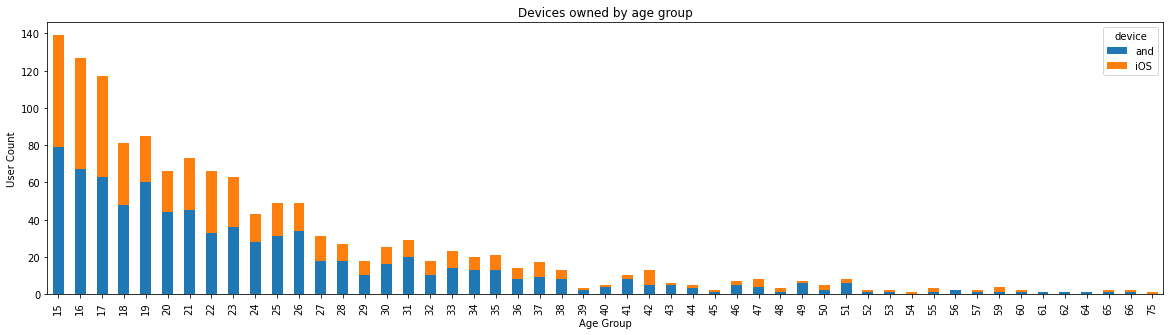

In [36]:
# exploring age group and devices
devices_age = uid_combined_data.groupby(['age', 'device']).agg({'uid': 'nunique'}).reset_index()

# Pivot the data
devices_age_pivot = devices_age.pivot(index='age', columns='device', values='uid')
devices_age_pivot = devices_age_pivot.fillna(0)  # Fill any missing values with 0

devices_age_pivot.plot(kind='bar', stacked=True, figsize = (20, 5))
plt.xlabel('Age Group')
plt.ylabel('User Count')
plt.title("Devices owned by age group")
plt.show()

<b> Observation </b>
<ul>
<li>There are more users who use android devices</li>
<li> Android devices generate more revenue on average. </li>
<li> Males and female users own more android devices.</li>
<li>Females who make up more of the users, make up more of the android devices held.</li>
<li> In all the countries, we have more android users than IOS. </li>
</ul>
 



### Exploring Purchases Over Time  & Seasonality


In [37]:
uid_combined_data['date'] = pd.to_datetime(uid_combined_data['date']).dt.date
uid_combined_data['reg_date'] = pd.to_datetime(uid_combined_data['reg_date'],format='%Y-%m-%d').dt.date

<AxesSubplot:title={'center':'Average Weekly Purchases'}, xlabel='Week', ylabel='Average Price'>

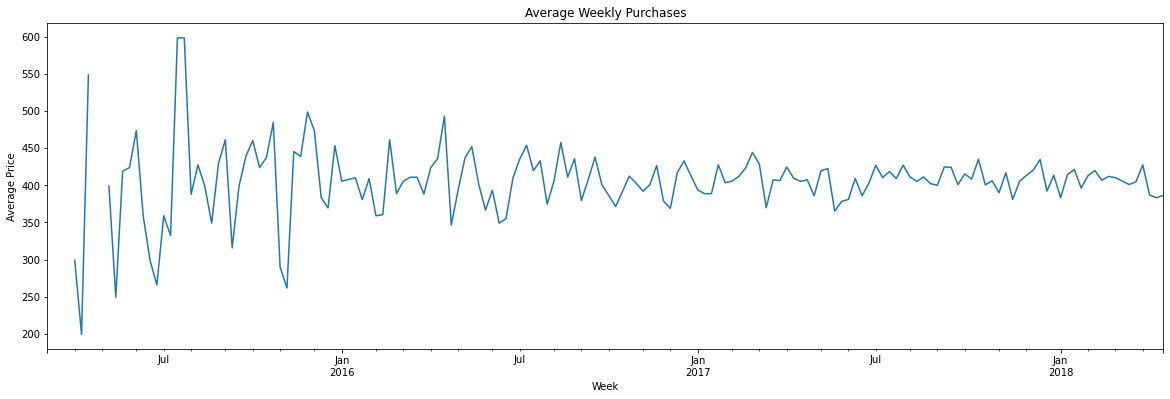

In [38]:
weekly_data_temp = uid_combined_data.copy()

# setting the date as an index
weekly_data_temp.index = pd.DatetimeIndex(weekly_data_temp.date)

# creating a frequency of week on the date index
weekly_data = weekly_data_temp.groupby(pd.Grouper(freq='W'))['price'].mean()

# Plot the average weekly purchases
weekly_data.plot(kind='line', figsize=(20, 6), xlabel='Week', ylabel='Average Price', title='Average Weekly Purchases')

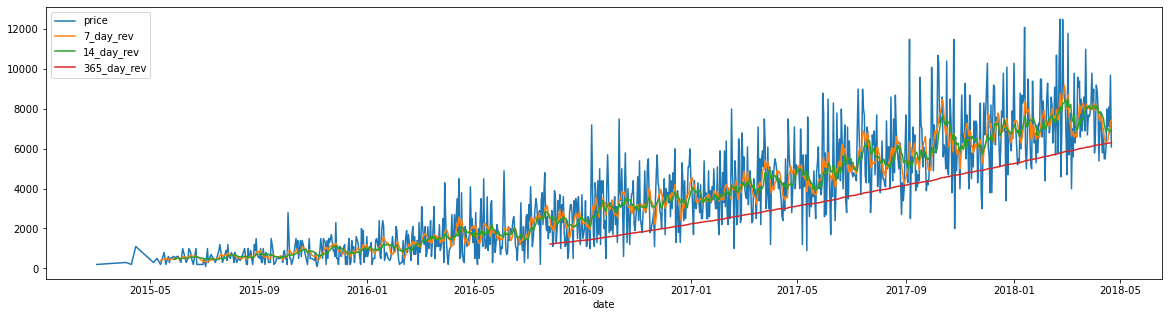

In [39]:
##### Exploring seasonality in the data #####
# looking at weekly, monthly and yearly trends in the data

daily_revenue = uid_combined_data.groupby(by=['date']).agg({'price': ['sum']})
daily_revenue.columns = daily_revenue.columns.droplevel(level=1)
daily_revenue.reset_index(inplace=True)

# Compute 7_day_rev
daily_revenue['7_day_rev'] = daily_revenue.price.rolling(window=7, center= False).mean()

# Compute 14_day_rev
daily_revenue['14_day_rev'] = daily_revenue.price.rolling(window=14, center= False).mean()

# Compute 28_day_rev
daily_revenue['28_day_rev'] = daily_revenue.price.rolling(window=28, center= False).mean()

# Compute 365_day_rev
daily_revenue['365_day_rev'] = daily_revenue.price.rolling(window=365, center= False).mean()

daily_revenue.plot(x='date', y=['price', '7_day_rev', '14_day_rev', '365_day_rev'], figsize=(20, 5))
plt.show()

<b> Observation </b>
<ul>
<li> The product seems to be going well over time, but there seems to be a dip after 2018-01</li>
</ul>

In [40]:
# Convert 'date' and 'reg_date' columns to datetime with timezone information
uid_combined_data['date'] = pd.to_datetime(uid_combined_data['date']).dt.tz_localize('UTC')
uid_combined_data['reg_date'] = pd.to_datetime(uid_combined_data['reg_date']).dt.tz_localize('UTC')

# Subtract the datetime objects and calculate the difference in days
uid_combined_data['purchase_since_reg'] = (uid_combined_data['date'] - uid_combined_data['reg_date']).dt.days

# Display the updated dataframe
uid_combined_data.head()

,date,uid,sku,price,reg_date,device,gender,country,age,age_group,is_female,month,purchase_since_reg
0,2017-07-10 00:00:00+00:00,41195147,sku_three_499,499,2017-06-26 00:00:00+00:00,and,M,BRA,17,"(15, 20]",0,7,14
1,2017-07-15 00:00:00+00:00,41195147,sku_three_499,499,2017-06-26 00:00:00+00:00,and,M,BRA,17,"(15, 20]",0,7,19
2,2017-11-12 00:00:00+00:00,41195147,sku_four_599,599,2017-06-26 00:00:00+00:00,and,M,BRA,17,"(15, 20]",0,11,139
3,2017-09-26 00:00:00+00:00,91591874,sku_two_299,299,2017-01-05 00:00:00+00:00,and,M,TUR,17,"(15, 20]",0,9,264
4,2017-12-01 00:00:00+00:00,91591874,sku_four_599,599,2017-01-05 00:00:00+00:00,and,M,TUR,17,"(15, 20]",0,12,330


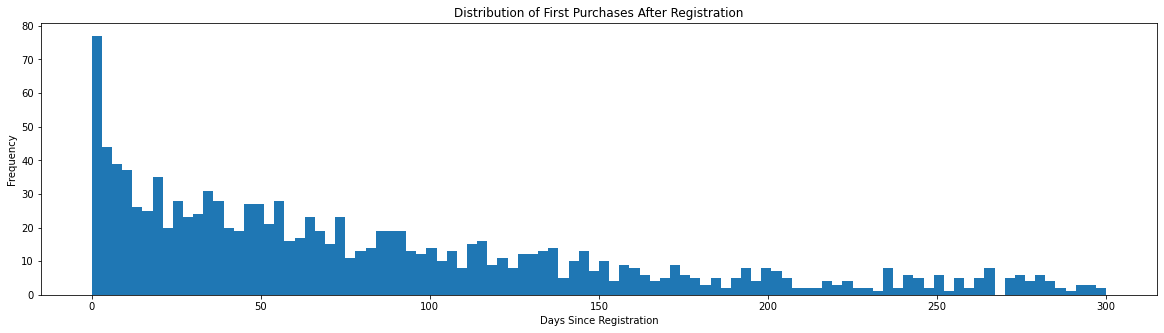

In [41]:
# Group the data by uid and reg_date, and select the first purchase made by each user, since users can make multiple purchases
first_purchases = uid_combined_data.groupby(['uid']).first()

# Plot the first purchases made by each user
first_purchases['purchase_since_reg'].plot(kind='hist', bins=100, figsize=(20, 5), range=(0, 300))

plt.xlabel('Days Since Registration')
plt.ylabel('Frequency')
plt.title('Distribution of First Purchases After Registration')
plt.show()

we can see that within the first 30 days we have a high density of purchases made 

In [42]:
first_purchases.describe()

,price,age,is_female,month,purchase_since_reg
count,1322.000000,1322.000000,1322.000000,1322.000000,1322.000000
mean,411.254160,24.072617,0.538578,6.383510,110.438729
std,197.718789,9.555172,0.498698,3.572178,124.880580
min,99.000000,15.000000,0.000000,1.000000,0.000000
25%,199.000000,17.000000,0.000000,3.000000,26.250000
50%,299.000000,21.000000,1.000000,7.000000,70.000000
75%,599.000000,28.000000,1.000000,10.000000,145.000000
max,899.000000,75.000000,1.000000,12.000000,1027.000000


In [43]:
# how many bought multiple times within the 7 days - business rule is 7 days to register
users_7 = uid_combined_data[uid_combined_data['purchase_since_reg'] <= 7]
users_7_counts = users_7.groupby('uid')['sku'].count()

first_purchase_users = (users_7_counts > 0).sum()
print('{} bought more than one subscription within the first 7 days, thats {}% of the users'.format(first_purchase_users, \
                                                                first_purchase_users/uid_combined_data.uid.nunique()*100))

203 bought more than one subscription within the first 7 days, thats 15.35552193645991% of the users


<b> Observation </b>
<ul>
<li> The average purchase price is consistently above $3 for subscribing users after Jan 2016</li>
<li> Most purchases were made within the first month</li> 
<li> The average time between registering and making a first subscription purchase is 110 days, with a minimum of 0 days and a maximum of 1000+ days </li>
<li> The app generate 15% conversion rate within the first 7 days, out of which 1% bought more than one package.</li>
</ul>

## Exploring Transactions

In [44]:
# calculating basket size and transaction value

# total items sold
total_items_sold = uid_combined_data.sku.count()

# total transactions 
total_transactions = len(uid_combined_data)

# average basket size
avg_basket_size = total_items_sold/total_transactions

# total revenue 
total_revenue  = uid_combined_data.price.sum()

# transaction value 
transaction_value = total_revenue/total_transactions

print('Total Items Sold: {}'.format(total_items_sold))
print('Total Transactions: {}'.format(total_transactions))
print('Total Revenue: {}'.format(total_revenue))
print('Average Basket Size/ average transaction per user : {}'.format(avg_basket_size))
print('Average Transaction Value: {}'.format(transaction_value))


Total Items Sold: 9006
Total Transactions: 9006
Total Revenue: 3663394
Average Basket Size/ average transaction per user : 1.0
Average Transaction Value: 406.77259604707973


Text(0.5, 1.0, 'Popular packages based on the number of transactions')

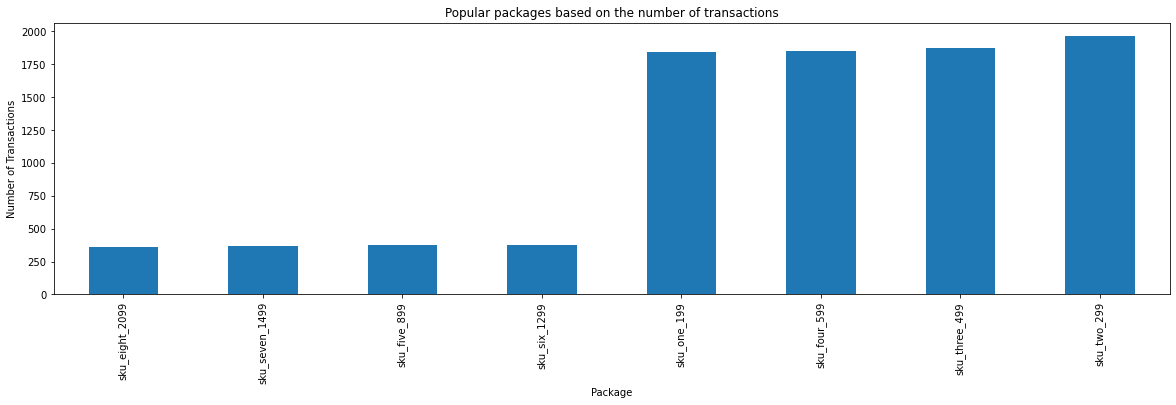

In [45]:
# drill down to the different sku's
popular_packages = uid_combined_data.groupby('sku')['uid'].count()

popular_packages.sort_values().plot(kind='bar', figsize=(20, 5))
plt.xlabel('Package')
plt.ylabel('Number of Transactions')
plt.title('Popular packages based on the number of transactions')

GMV by package type: 
sku
sku_eight_2099      35343
sku_five_899       334428
sku_four_599      1106952
sku_one_199        366160
sku_seven_1499     182135
sku_six_1299       113321
sku_three_499      936623
sku_two_299        588432
dtype: int64


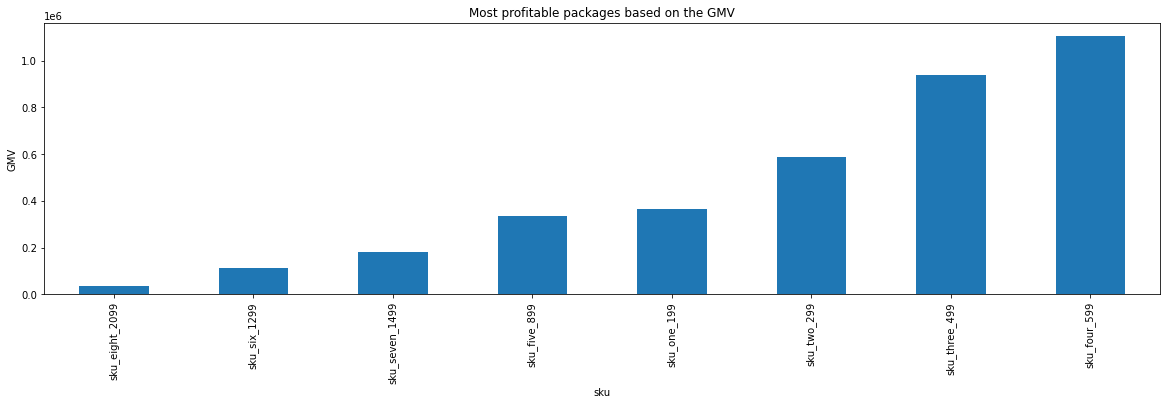

In [52]:
# GMV, due to the fact that there transaction_id is not present, we will operate under the assumption that each row is a transaction (one item per transaction)

uid_combined_data['quantity'] = 1
gmv = uid_combined_data.groupby('sku').apply(lambda x: (x['price'] * x['quantity']).sum())
print("GMV by package type: \n{}".format(gmv))

gmv.sort_values().plot(kind='bar', figsize=(20, 5))
plt.title('Most profitable packages based on the GMV')
plt.ylabel('GMV')
plt.show()


In [53]:
# total gmv 
total_gmv = uid_combined_data.price.sum()
print('Total GMV: {}'.format(total_gmv))

Total GMV: 3663394


In [54]:
# average sales price
units_sold = uid_combined_data.groupby('sku')['quantity'].sum()
average_sales_price = gmv/units_sold

print('Average Sales Price: \n{}'.format(average_sales_price))

Average Sales Price: 
sku
sku_eight_2099     99.0
sku_five_899      899.0
sku_four_599      599.0
sku_one_199       199.0
sku_seven_1499    499.0
sku_six_1299      299.0
sku_three_499     499.0
sku_two_299       299.0
dtype: float64


<b>Observations</b>
<ul>
<li>A total of 9,006 items were sold across 9,006 transactions, generating a total revenue of 3,663,394.</li>
<li>The average basket size is 1.0, indicating that users typically purchase one item per transaction.</li>
<li>The average transaction value is 406.77, which is the average amount spent by a user in a single transaction.</li>
<li>The most popular package types are sku_four_599, sku_three_499, and sku_two_299, with 1,848, 1,877, and 1,968 units sold, respectively.</li>
<li>The highest GMV was generated by sku_four_599, contributing 1,106,952 to the total GMV of 3,663,394.</li>
<li>The average sales price is equal to the price of each SKU, as there were no discounts or price variations in the transactions.</li>
</ul>

### Customer life time value 

In [63]:
# average customer lifespan 

uid_combined_data['date'] = pd.to_datetime(uid_combined_data['date'])

# Group the data by 'uid' and find the first and last transaction dates
first_purchase = uid_combined_data.groupby('uid')['date'].min()
last_purchase = uid_combined_data.groupby('uid')['date'].max()

# Calculate the length of time between the first and last transaction for each customer
customer_lifespan = (last_purchase - first_purchase).dt.days

# Calculate the average length of time across all customers
average_customer_lifespan = customer_lifespan.mean()

print("Average Customer Lifespan (in days):", average_customer_lifespan)


Average Customer Lifespan (in days): 360.5574886535552


In [64]:
# purchase_frequency = total_transactions/uid_combined_data.uid.nunique()
# clv = transaction_value * purchase_frequency * average_customer_lifespan
# print("Customer Lifetime Value (CLV):", clv)

Customer Lifetime Value (CLV): 999140.8022605916
